## AP-1 Design With Beluga/DeepSEA

In this first tutorial we will demonstrate how to use Ledidi to design edits when using a multi-task model such as DeepSEA/Beluga. Here, we will focus on the setting where you one want to make edits to effect one of the outputs and do not care too much about the other tasks.

The Beluga model we will use can be found on Kipoi: https://kipoi.org/models/DeepSEA/

The model is saved as a dictionary of weights and requires you to define the model architecture. The model definition is also taken from the Kipoi repo and can be found here: https://github.com/kipoi/models/blob/master/DeepSEA/beluga/model.py

Importantly, the final sigmoid activation layer should be removed so that Ledidi can operate in logit space rather than probability space. Ledidi can work in probability space, especially when given the right loss function, but optimizing in logit space is conceptually simpler and is likely to lead to better results.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
from torch import nn

class LambdaBase(nn.Sequential):
    def __init__(self, fn, *args):
        super(LambdaBase, self).__init__(*args)
        self.lambda_func = fn

    def forward_prepare(self, input):
        output = []
        for module in self._modules.values():
            output.append(module(input))
        return output if output else input


class Lambda(LambdaBase):
    def forward(self, input):
        return self.lambda_func(self.forward_prepare(input))


class Beluga(nn.Module):
    def __init__(self):
        super(Beluga, self).__init__()
        self.model = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(4, 320, (1, 8)),
                nn.ReLU(),
                nn.Conv2d(320, 320, (1, 8)),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.MaxPool2d((1, 4), (1, 4)),
                nn.Conv2d(320, 480, (1, 8)),
                nn.ReLU(),
                nn.Conv2d(480, 480, (1, 8)),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.MaxPool2d((1, 4), (1, 4)),
                nn.Conv2d(480, 640, (1, 8)),
                nn.ReLU(),
                nn.Conv2d(640, 640, (1, 8)),
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.Dropout(0.5),
                Lambda(lambda x: x.view(x.size(0), -1)),
                nn.Sequential(Lambda(lambda x: x.view(1, -1) if 1 == len(x.size()) else x), nn.Linear(67840, 2003)),
                nn.ReLU(),
                nn.Sequential(Lambda(lambda x: x.view(1, -1) if 1 == len(x.size()) else x), nn.Linear(2003, 2002)),
            )
            #nn.Sigmoid(), # Remove the final logit layer
        )

    def forward(self, x):
        return self.model(x)
    
model = Beluga()
model.load_state_dict(torch.load('beluga.pth'))
model = model.eval().cuda()

### Deleting AP-1

Now, we will load up a locus that was found to have AP-1 binding and is also correct predicted to have AP-1 binding. We will use bpnet-lite for some simple processing scripts but it is not a requirement of Ledidi. Any library for one-hot encoding sequences is fine as long as the shape matches what is expected by the model.

In [2]:
import numpy
import pyfaidx
from bpnetlite.io import one_hot_encode

chrom, start, end = 'chr2', 1930500, 1932500
seq = pyfaidx.Fasta("hg38.fa")[chrom][start:end].seq.upper()

X = one_hot_encode(seq).T.astype(numpy.float32)
X = torch.from_numpy(X).unsqueeze(0).unsqueeze(2).cuda()

y = model(X)[0, 309]
y

tensor(1.2316, device='cuda:0', grad_fn=<SelectBackward0>)

To confirm this is the case we can look at the attributions for the JunD in HepG2. JunD is in the AP-1 family of proteins that all bind to the same binding site.

Populating the interactive namespace from numpy and matplotlib


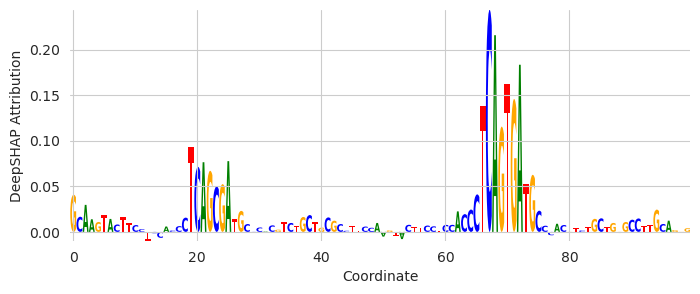

In [3]:
%pylab inline
import seaborn; seaborn.set_style('whitegrid')

from captum.attr import DeepLiftShap

from bpnetlite.attributions import dinucleotide_shuffle
from bpnetlite.attributions import hypothetical_attributions
from bpnetlite.attributions import plot_attributions

references = dinucleotide_shuffle(X[0, :, 0].cpu(), n_shuffles=20, random_state=0).unsqueeze(2).cuda()

ig = DeepLiftShap(model)
attr = ig.attribute(X, references, target=309, custom_attribution_func=hypothetical_attributions)
attr = (attr * X).cpu().detach().numpy()[0, :, 0]

plt.figure(figsize=(8, 3))
ax = plt.subplot(111)
plot_attributions(attr[:, 950:1050], ax=ax)
plt.xlabel("Coordinate")
plt.ylabel("DeepSHAP Attribution")
plt.show()

As expected, there are clearly two AP-1 binding sites hanging out together here that are driving the predictions.

Now, let's use Ledidi to design edits that will knock out JunD binding. To do this, we have to define a desired output from the model, `y_bar`. Since we are operating in logit space this should be a negative number. When setting this number, keep in mind that there is a trade-off between the output loss and the input loss. Even when you want to completely knock out signal, setting this value too low will cause Ledidi to make more edits to achieve the goal. Let's choose a desired output of -2. 

In [4]:
from ledidi import Ledidi

torch.manual_seed(0)

y_bar = torch.zeros(1, dtype=torch.float32, device='cuda') - 2

designer = Ledidi(model, X.shape[1:], target=309, tau=0.1, l=1, max_iter=20000, report_iter=1000).cuda()
X_hat = designer.fit_transform(X, y_bar)

iter=I	input_loss=0	output_loss=10.44	total_loss=10.44
iter=0	input_loss=0.5938	output_loss=10.49	total_loss=11.09	time=0.1069
iter=1000	input_loss=0.375	output_loss=10.39	total_loss=10.77	time=10.55
iter=2000	input_loss= 7.0	output_loss=0.3385	total_loss=7.339	time=10.44
iter=3000	input_loss=5.781	output_loss=0.434	total_loss=6.215	time=10.5
iter=4000	input_loss=5.25	output_loss=0.1052	total_loss=5.355	time=10.55
iter=5000	input_loss=4.625	output_loss=0.4183	total_loss=5.043	time=10.59
iter=6000	input_loss=5.062	output_loss=0.2962	total_loss=5.359	time=10.52
iter=7000	input_loss=5.031	output_loss=0.3326	total_loss=5.364	time=10.56
iter=8000	input_loss=5.031	output_loss=0.3351	total_loss=5.366	time=10.62
iter=9000	input_loss=5.156	output_loss=0.2562	total_loss=5.412	time=10.65
iter=10000	input_loss=5.688	output_loss=0.1557	total_loss=5.843	time=10.65
iter=11000	input_loss=4.344	output_loss=0.8499	total_loss=5.194	time=10.7
iter=12000	input_loss=5.094	output_loss=0.2076	total_loss=5.301

See how simple that was? Just a few lines of code turns Beluga into a sequence editor.

Now, `X_hat` is not going to be a single sequence but rather a batch of randomly selected sequences from the iteration with the lowest `total_loss`. If no iterations have a lower `total_loss` than the initial iteration (I), the original sequence is returned.

We can score these sequences according to the number of edits made in each one as well as the model output, to see how close they got to the objective.

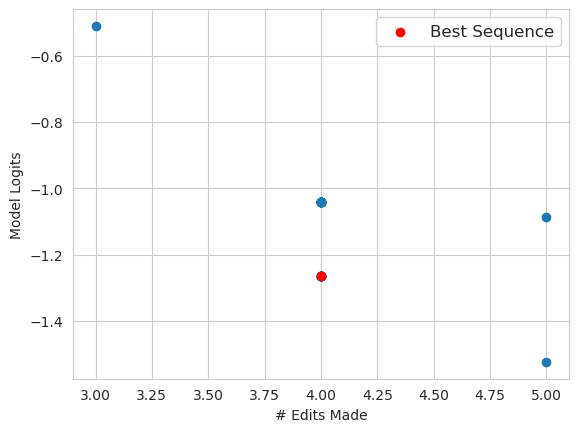

In [5]:
y_hat = model(X_hat)[:, 309].cpu().detach().numpy()

input_loss = torch.abs(X_hat - X).sum(axis=(1, 2, 3)).cpu().detach().numpy() // 2
output_loss = numpy.square(y_bar.cpu().detach().numpy() - y_hat)

best_idx = numpy.argmin(input_loss + designer.l * output_loss)

plt.scatter(input_loss, y_hat)
plt.scatter(input_loss[best_idx], y_hat[best_idx], c='r', label="Best Sequence")
plt.legend(fontsize=12)
plt.xlabel("# Edits Made")
plt.ylabel("Model Logits")
plt.show()

Looks like the best sequence made four edits and went from a positive predicted logit to a negative one.

We can take a look at the attribution scores again and check out whether the edits were made in high attribution sites.

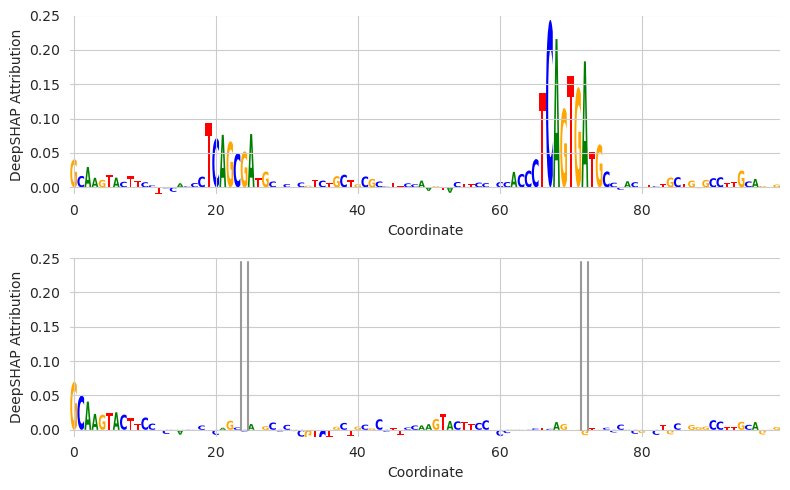

In [6]:
references = dinucleotide_shuffle(X_hat[best_idx, :, 0].cpu(), n_shuffles=20, random_state=0).unsqueeze(2).cuda()

ig = DeepLiftShap(model)
attr_hat = ig.attribute(X_hat[best_idx:best_idx+1], references, target=309, 
    custom_attribution_func=hypothetical_attributions)
attr_hat = (attr_hat * X_hat[best_idx]).cpu().detach().numpy()[0, :, 0]


plt.figure(figsize=(8, 5))
ax = plt.subplot(211)
plot_attributions(attr[:, 950:1050], ax=ax)
plt.xlabel("Coordinate")
plt.ylabel("DeepSHAP Attribution")
plt.ylim(-0.01, 0.25)

ax = plt.subplot(212)
plot_attributions(attr_hat[:, 950:1050], ax=ax)
diff_idxs = torch.where(torch.abs(X_hat - X)[best_idx, :, 0].sum(axis=0) != 0)[0].cpu()

for idx in diff_idxs:
    if idx > 950 and idx < 1050:
        plt.plot([idx-950-0.5, idx-950-0.5], [0, attr.max()], color='0.6')
        plt.plot([idx+0.5-950, idx+0.5-950], [0, attr.max()], color='0.6')
        
plt.xlabel("Coordinate")
plt.ylabel("DeepSHAP Attribution")
plt.ylim(-0.01, 0.25)

plt.tight_layout()
plt.show()

Looks like two of the four edits were made right in the middle of these binding sites and resulted in knocking them out completely!

There are only a few parameters to be concerned about with Ledidi.

If we want to create more sequences we can keep querying Ledidi.

In [7]:
X_hat = torch.cat([designer(X) for i in range(100)])
X_hat.shape

torch.Size([3200, 4, 1, 2000])

Now we have 3200 sequences instead of 32.

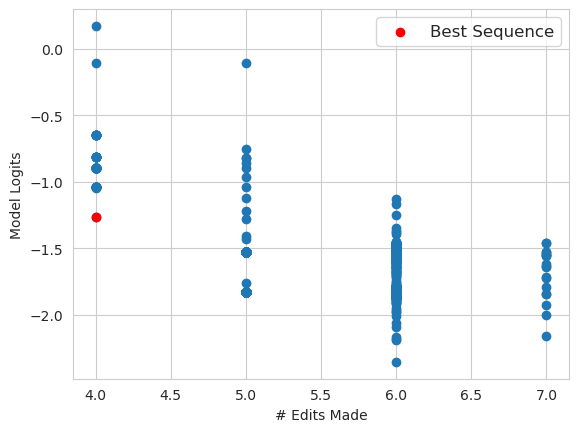

In [8]:
y_hat = model(X_hat)[:, 309].cpu().detach().numpy()

input_loss = torch.abs(X_hat - X).sum(axis=(1, 2, 3)).cpu().detach().numpy() // 2
output_loss = numpy.square(y_bar.cpu().detach().numpy() - y_hat)

best_idx = numpy.argmin(input_loss + designer.l * output_loss)

plt.scatter(input_loss, y_hat)
plt.scatter(input_loss[best_idx], y_hat[best_idx], c='r', label="Best Sequence")
plt.legend(fontsize=12)
plt.xlabel("# Edits Made")
plt.ylabel("Model Logits")
plt.show()

We can see way more diversity in these sequences! As more edits are made, sequences have closer to the desired logits of -2. 

### Adding in a motif

Next, let's look at trying to add in an AP-1 motif to a sequence that currently does not have high JunD ChIP-seq predictions according to the model.

In [9]:
chrom, start, end = 'chr2', 1870500, 1872500
seq = pyfaidx.Fasta("hg38.fa")[chrom][start:end].seq.upper()

X = one_hot_encode(seq).T.astype(numpy.float32)
X = torch.from_numpy(X).unsqueeze(0).unsqueeze(2).cuda()

y = model(X)[0, 309]
y

tensor(-6.5655, device='cuda:0')

The only change we need to do to get Ledidi to try to add in a motif rather than delete a motif is have the desired output be positive instead of negative. As a technical note, you usually need to change the balance between the input loss and the output loss when moving from a motif deleting to a motif insertion task because one would expect there to be more edits when adding in activitity than simply deleting it. We do so here by just increasing `l` from 1 to 2.

In [10]:
torch.manual_seed(0)

y_bar = torch.zeros(1, dtype=torch.float32, device='cuda') + 2

designer = Ledidi(model, X.shape[1:], target=309, tau=0.1, l=2, max_iter=20000, report_iter=1000).cuda()
X_hat = designer.fit_transform(X, y_bar)

iter=I	input_loss=0	output_loss=73.37	total_loss=146.7
iter=0	input_loss= 0.5	output_loss=73.54	total_loss=147.6	time=0.005522
iter=1000	input_loss=9.781	output_loss=49.63	total_loss=109.0	time=10.69
iter=2000	input_loss=24.62	output_loss=4.025	total_loss=32.67	time=10.68
iter=3000	input_loss=23.06	output_loss=2.881	total_loss=28.82	time=10.75
iter=4000	input_loss=20.0	output_loss=1.664	total_loss=23.33	time=12.81
iter=5000	input_loss=18.88	output_loss=1.288	total_loss=21.45	time=18.99
iter=6000	input_loss=17.59	output_loss=1.388	total_loss=20.37	time=19.55
iter=7000	input_loss=17.78	output_loss=1.284	total_loss=20.35	time=19.65
iter=8000	input_loss=18.09	output_loss=1.031	total_loss=20.16	time=19.15
iter=9000	input_loss=18.16	output_loss=0.9122	total_loss=19.98	time=19.11
iter=10000	input_loss=17.75	output_loss=0.9739	total_loss=19.7	time=19.44
iter=11000	input_loss=18.0	output_loss=0.9574	total_loss=19.91	time=19.31
iter=12000	input_loss=18.38	output_loss=0.7634	total_loss=19.9	time=

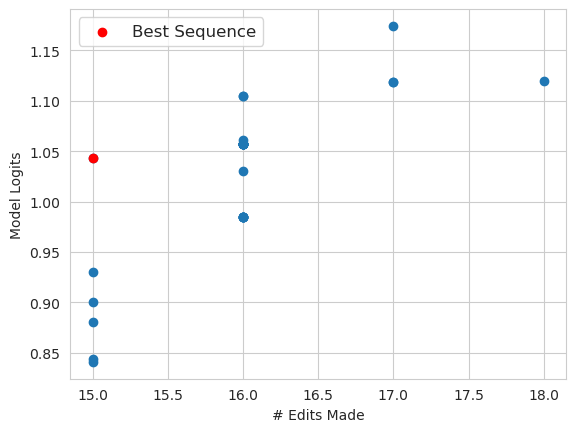

In [11]:
y_hat = model(X_hat)[:, 309].cpu().detach().numpy()

input_loss = torch.abs(X_hat - X).sum(axis=(1, 2, 3)).cpu().detach().numpy() // 2
output_loss = numpy.square(y_bar.cpu().detach().numpy() - y_hat)

best_idx = numpy.argmin(input_loss + designer.l * output_loss)

plt.scatter(input_loss, y_hat)
plt.scatter(input_loss[best_idx], y_hat[best_idx], c='r', label="Best Sequence")
plt.legend(fontsize=12)
plt.xlabel("# Edits Made")
plt.ylabel("Model Logits")
plt.show()

Similarly to the motif deletion setting we can see that more edits means getting closer to the goal. However, the best chosen identified sequence is not the one with highest logit just due to the balance between the number of edits and small improvement in the logit.

Let's take a look at the edits made.

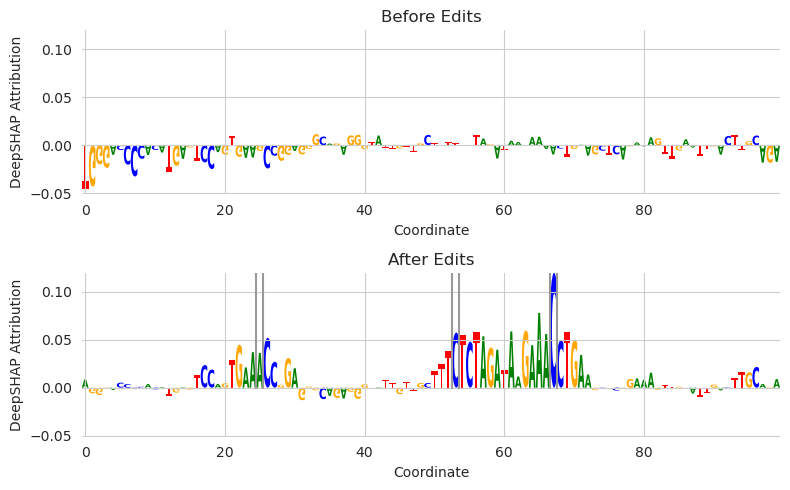

In [12]:
ig = DeepLiftShap(model)

references = dinucleotide_shuffle(X[0, :, 0].cpu(), n_shuffles=20, random_state=0).unsqueeze(2).cuda()
attr = ig.attribute(X, references, target=309, custom_attribution_func=hypothetical_attributions)
attr = (attr * X).cpu().detach().numpy()[0, :, 0]

references = dinucleotide_shuffle(X_hat[best_idx, :, 0].cpu(), n_shuffles=20, random_state=0).unsqueeze(2).cuda()
attr_hat = ig.attribute(X_hat[best_idx:best_idx+1], references, target=309, custom_attribution_func=hypothetical_attributions)
attr_hat = (attr_hat * X_hat[best_idx]).cpu().detach().numpy()[0, :, 0]

diff_idxs = torch.where(torch.abs(X_hat - X)[best_idx, :, 0].sum(axis=0) != 0)[0].cpu().numpy()

start, end = 975, 1075

plt.figure(figsize=(8, 5))
ax = plt.subplot(211)
plt.title("Before Edits", fontsize=12)
plot_attributions(attr[:, start:end], ax=ax)
plt.ylim(attr.min(), attr_hat.max())
plt.xlabel("Coordinate")
plt.ylabel("DeepSHAP Attribution")

ax = plt.subplot(212)
plt.title("After Edits", fontsize=12)
plot_attributions(attr_hat[:, start:end], ax=ax)

for idx in diff_idxs:
    if idx > start and idx < end:        
        plt.plot([idx-start-0.5, idx-start-0.5], [0, attr_hat.max()], color='0.6')
        plt.plot([idx-start+0.5, idx-start+0.5], [0, attr_hat.max()], color='0.6')

plt.ylim(attr.min(), attr_hat.max())
plt.xlabel("Coordinate")
plt.ylabel("DeepSHAP Attribution")

plt.tight_layout()
plt.show()

We can see that, initially, there is only low attribution for all the nucleotides. After making the changes (of which only a subset are shown in this window) we can see that some spans are starting to achieve high attribution! Interestingly, it seems like the SIX2 motif is being highlighted as opposed to a canonical AP-1 motif. I won't demonstrate this here, but this is a good example of Ledidi being limited by the performance of the model it is paired with. Beluga thinks that SIX2 motifs are indicative of binding and Ledidi cannot overcome that error.

### Controlled design: inputs

Ledidi is extremely flexible and there are several ways to control the design process. The simplest is to alter the initial weight matrix that Ledidi uses instead of having it be all zeroes. For example, let's return to the AP-1 deletion example.

In [13]:
chrom, start, end = 'chr2', 1930500, 1932500
seq = pyfaidx.Fasta("hg38.fa")[chrom][start:end].seq.upper()

X = one_hot_encode(seq).T.astype(numpy.float32)
X = torch.from_numpy(X).unsqueeze(0).unsqueeze(2).cuda()

y = model(X)[0, 309]
y

tensor(1.2316, device='cuda:0')

Remember, there were two AP-1 motifs. What happens when we mask out all the positions except for a window surrounding the left one? This would limit the number of edits to 

In [14]:
y_bar = torch.zeros(1, dtype=torch.float32, device='cuda') - 1
input_mask = torch.ones(2000, dtype=torch.bool, device='cuda')
input_mask[950:990] = False

designer = Ledidi(model, X.shape[1:], target=309, tau=0.1, l=1, input_mask=input_mask,
                  max_iter=10000, report_iter=1000).cuda()
X_hat = designer.fit_transform(X, y_bar)

iter=I	input_loss=0	output_loss=4.98	total_loss=4.98
iter=0	input_loss=0.03125	output_loss=4.979	total_loss=5.01	time=0.005772
iter=1000	input_loss= 0.0	output_loss=4.98	total_loss=4.98	time=10.64
iter=2000	input_loss=2.062	output_loss=2.664	total_loss=4.726	time=10.68
iter=3000	input_loss= 2.0	output_loss=2.685	total_loss=4.685	time=10.69
iter=4000	input_loss= 2.0	output_loss=2.685	total_loss=4.685	time=10.68
iter=5000	input_loss= 2.0	output_loss=2.685	total_loss=4.685	time=10.67
iter=6000	input_loss= 2.0	output_loss=2.685	total_loss=4.685	time=10.67
iter=7000	input_loss= 2.0	output_loss=2.685	total_loss=4.685	time=10.72
iter=8000	input_loss= 2.0	output_loss=2.685	total_loss=4.685	time=10.66
iter=9000	input_loss= 2.0	output_loss=2.685	total_loss=4.685	time=10.71
iter=10000	input_loss=2.094	output_loss=2.662	total_loss=4.756	time=10.65


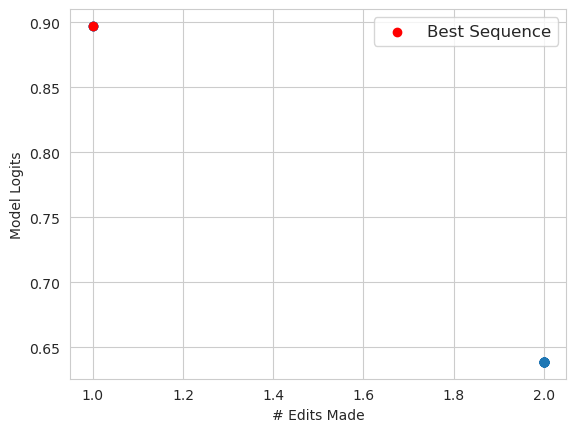

In [15]:
y_hat = model(X_hat)[:, 309].cpu().detach().numpy()

input_loss = torch.abs(X_hat - X).sum(axis=(1, 2, 3)).cpu().detach().numpy() // 2
output_loss = numpy.square(y_bar.cpu().detach().numpy() - y_hat)

best_idx = numpy.argmin(input_loss + designer.l * output_loss)

plt.scatter(input_loss, y_hat)
plt.scatter(input_loss[best_idx], y_hat[best_idx], c='r', label="Best Sequence")
plt.legend(fontsize=12)
plt.xlabel("# Edits Made")
plt.ylabel("Model Logits")
plt.show()

It looks like most of the samples sequences are producing the same edit! But the goal did not seem to really be achieved -- the logit is still pretty positive. This is probably due to the very constrained nature of the design task. Let's take a look at what nucleotide got edited.

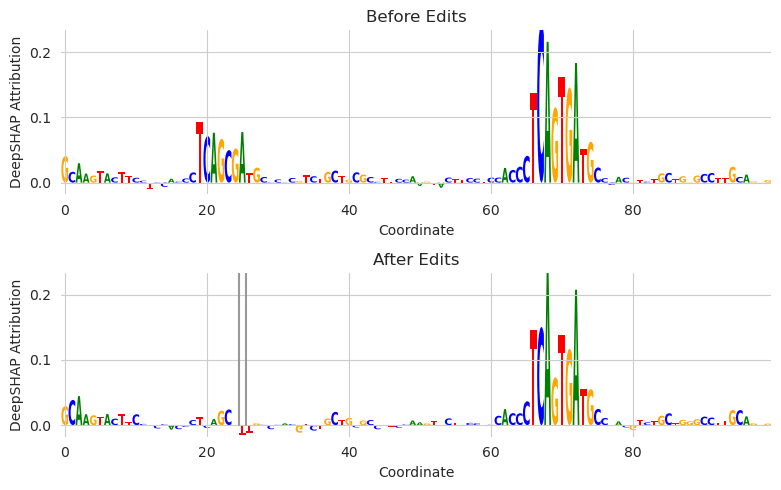

In [16]:
ig = DeepLiftShap(model)

references = dinucleotide_shuffle(X[0, :, 0].cpu(), n_shuffles=20, random_state=0).unsqueeze(2).cuda()
attr = ig.attribute(X, references, target=309, custom_attribution_func=hypothetical_attributions)
attr = (attr * X).cpu().detach().numpy()[0, :, 0]

references = dinucleotide_shuffle(X_hat[best_idx, :, 0].cpu(), n_shuffles=20, random_state=0).unsqueeze(2).cuda()
attr_hat = ig.attribute(X_hat[best_idx:best_idx+1], references, target=309, custom_attribution_func=hypothetical_attributions)
attr_hat = (attr_hat * X_hat[best_idx]).cpu().detach().numpy()[0, :, 0]

diff_idxs = torch.where(torch.abs(X_hat - X)[best_idx, :, 0].sum(axis=0) != 0)[0].cpu().numpy()

start, end = 950, 1050

plt.figure(figsize=(8, 5))
ax = plt.subplot(211)
plt.title("Before Edits", fontsize=12)
plot_attributions(attr[:, start:end], ax=ax)
plt.ylim(attr.min(), attr_hat.max())
plt.xlabel("Coordinate")
plt.ylabel("DeepSHAP Attribution")

ax = plt.subplot(212)
plt.title("After Edits", fontsize=12)
plot_attributions(attr_hat[:, start:end], ax=ax)

for idx in diff_idxs:
    if idx > start and idx < end:        
        plt.plot([idx-start-0.5, idx-start-0.5], [0, attr_hat.max()], color='0.6')
        plt.plot([idx-start+0.5, idx-start+0.5], [0, attr_hat.max()], color='0.6')

plt.ylim(attr.min(), attr_hat.max())
plt.xlabel("Coordinate")
plt.ylabel("DeepSHAP Attribution")

plt.tight_layout()
plt.show()

Ledidi has the ability to edit any of the first 40 nucleotides in this sequence. As expected, it ended up making one edit within the AP-1 site and completely knocked it out!

Now, what happens when we limit edits to the next 40 nucleotides?

In [17]:
y_bar = torch.zeros(1, dtype=torch.float32, device='cuda') - 1
input_mask = torch.ones(2000, dtype=torch.bool, device='cuda')
input_mask[990:1030] = False

designer = Ledidi(model, X.shape[1:], target=309, tau=0.1, l=1, input_mask=input_mask,
                  max_iter=10000, report_iter=1000).cuda()

X_hat = designer.fit_transform(X, y_bar)

iter=I	input_loss=0	output_loss=4.98	total_loss=4.98
iter=0	input_loss=0.03125	output_loss=4.992	total_loss=5.023	time=0.005237
iter=1000	input_loss= 1.0	output_loss=3.502	total_loss=4.502	time=10.67
iter=2000	input_loss=1.938	output_loss=1.95	total_loss=3.888	time=10.66
iter=3000	input_loss= 1.0	output_loss= 2.0	total_loss= 3.0	time=10.64
iter=4000	input_loss= 1.0	output_loss=1.834	total_loss=2.834	time=13.57
iter=5000	input_loss=1.062	output_loss=1.816	total_loss=2.878	time=10.99
iter=6000	input_loss= 1.0	output_loss=1.834	total_loss=2.834	time=10.66
iter=7000	input_loss= 1.0	output_loss=1.834	total_loss=2.834	time=12.75
iter=8000	input_loss= 1.0	output_loss=1.834	total_loss=2.834	time=19.13
iter=9000	input_loss= 1.0	output_loss=1.834	total_loss=2.834	time=19.09
iter=10000	input_loss= 1.0	output_loss=1.834	total_loss=2.834	time=19.68


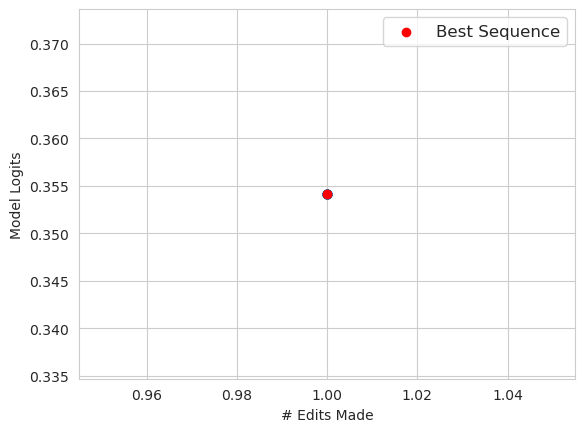

In [18]:
y_hat = model(X_hat)[:, 309].cpu().detach().numpy()

input_loss = torch.abs(X_hat - X).sum(axis=(1, 2, 3)).cpu().detach().numpy() // 2
output_loss = numpy.square(y_bar.cpu().detach().numpy() - y_hat)

best_idx = numpy.argmin(input_loss + designer.l * output_loss)

plt.scatter(input_loss, y_hat)
plt.scatter(input_loss[best_idx], y_hat[best_idx], c='r', label="Best Sequence")
plt.legend(fontsize=12)
plt.xlabel("# Edits Made")
plt.ylabel("Model Logits")
plt.show()

Similarly, only one nucleotide has been changed. However, the logit is much lower than when trying to eliminate the other one. Let's see which one?

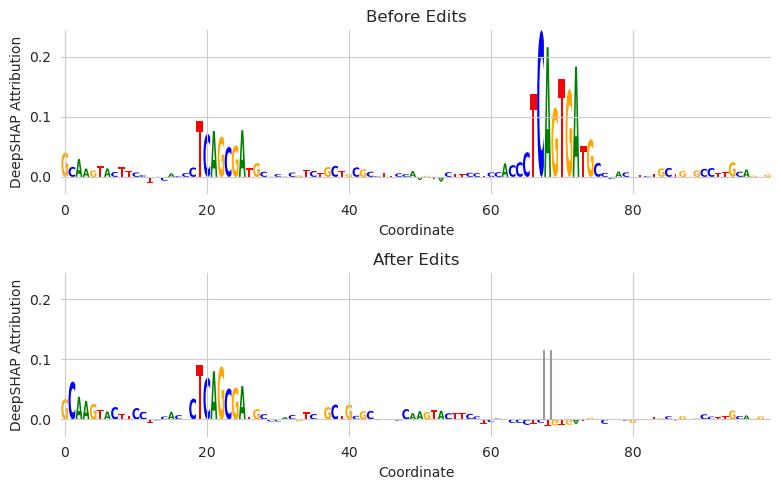

In [19]:
ig = DeepLiftShap(model)

references = dinucleotide_shuffle(X[0, :, 0].cpu(), n_shuffles=20, random_state=0).unsqueeze(2).cuda()
attr = ig.attribute(X, references, target=309, custom_attribution_func=hypothetical_attributions)
attr = (attr * X).cpu().detach().numpy()[0, :, 0]

references = dinucleotide_shuffle(X_hat[best_idx, :, 0].cpu(), n_shuffles=20, random_state=0).unsqueeze(2).cuda()
attr_hat = ig.attribute(X_hat[best_idx:best_idx+1], references, target=309, custom_attribution_func=hypothetical_attributions)
attr_hat = (attr_hat * X_hat[best_idx]).cpu().detach().numpy()[0, :, 0]

diff_idxs = torch.where(torch.abs(X_hat - X)[best_idx, :, 0].sum(axis=0) != 0)[0].cpu().numpy()

start, end = 950, 1050

plt.figure(figsize=(8, 5))
ax = plt.subplot(211)
plt.title("Before Edits", fontsize=12)
plot_attributions(attr[:, start:end], ax=ax)
plt.ylim(attr_hat.min(), attr.max())
plt.xlabel("Coordinate")
plt.ylabel("DeepSHAP Attribution")

ax = plt.subplot(212)
plt.title("After Edits", fontsize=12)
plot_attributions(attr_hat[:, start:end], ax=ax)

for idx in diff_idxs:
    if idx > start and idx < end:        
        plt.plot([idx-start-0.5, idx-start-0.5], [0, attr_hat.max()], color='0.6')
        plt.plot([idx-start+0.5, idx-start+0.5], [0, attr_hat.max()], color='0.6')

plt.ylim(attr_hat.min(), attr.max())
plt.xlabel("Coordinate")
plt.ylabel("DeepSHAP Attribution")

plt.tight_layout()
plt.show()

Looks like the second motif has been eliminated instead of the first one this time.